<a href="https://colab.research.google.com/github/prajachintya/Course_IORS/blob/main/knnc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# import libraries
from osgeo import gdal
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [34]:
# gdal constants
from gdalconst import *

In [35]:
# inform to use GDAL exceptions
gdal.UseExceptions()

In [36]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
%cd /content/drive/MyDrive/Colab Notebooks/citra

/content/drive/MyDrive/Colab Notebooks/citra


In [38]:
# open dataset
filename = "/content/drive/MyDrive/Colab Notebooks/citra/citra.tif"
dataset = gdal.Open(filename, GA_ReadOnly)

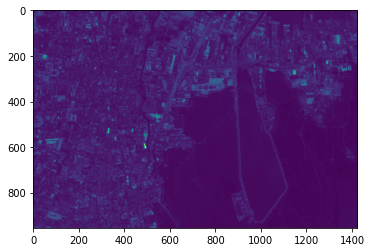

In [39]:

rb = dataset.GetRasterBand(3)
img_array = rb.ReadAsArray()
plt.imshow(img_array)
plt.show()

In [40]:
# retrieve metadata from raster
rows = dataset.RasterYSize
columns = dataset.RasterXSize
N = rows * columns
bands = dataset.RasterCount

In [41]:
# print basic metadata
print ("image metadata:")
print (rows, "rows x", columns, "columns x", bands, "bands")

image metadata:
955 rows x 1424 columns x 5 bands


In [42]:
# parameters for kNN algorithm
k = 5
max_distance = 100
min_distance = 1
actual_max_distance = min_distance



In [58]:
# parameters for colormap used by classification
default_colormap = 'Pastel1'

In [74]:
# retrieve arrays from input image, 3 channels in this case
array_R = dataset.GetRasterBand(1).ReadAsArray().astype(float)
array_G = dataset.GetRasterBand(2).ReadAsArray().astype(float)
array_B = dataset.GetRasterBand(3).ReadAsArray().astype(float)
array_RGB = np.zeros((rows, columns, 3), dtype=np.uint8)
array_RGB[:,:,0] = array_R
array_RGB[:,:,1] = array_G
array_RGB[:,:,2] = array_B
array_RGB_copy = array_RGB.copy()

print(array_RGB_copy)

[[[ 70  65  41]
  [ 83  67  51]
  [ 83  74  50]
  ...
  [ 29 118 201]
  [242 127 170]
  [182  96 121]]

 [[ 49  55  38]
  [ 47  47  40]
  [ 49  61  35]
  ...
  [253 112 178]
  [206  93 157]
  [154  58 123]]

 [[ 13  20  11]
  [ 23  15   3]
  [ 44  44  10]
  ...
  [180  77 130]
  [152  54 125]
  [136  49 130]]

 ...

 [[182 250 242]
  [159 226 219]
  [151 215 211]
  ...
  [ 81 218  81]
  [ 76 212  83]
  [ 72 220  94]]

 [[174 237 239]
  [160 213 222]
  [137 211 198]
  ...
  [ 78 217  81]
  [ 73 212  82]
  [ 72 219  90]]

 [[125 200 213]
  [107 178 196]
  [111 187 180]
  ...
  [ 75 220  84]
  [ 73 215  82]
  [ 72 213  83]]]


In [45]:
# samples for classification
# basic format (column, row, class number)
samples = []
samples.append((800, 0, 1))
samples.append((800, 1, 1))
samples.append((800, 2, 1))
samples.append((800, 3, 1))
samples.append((800, 4, 1))
samples.append((800, 5, 1))
samples.append((800, 6, 1))
samples.append((800, 7, 1))
samples.append((800, 8, 1))
samples.append((800, 9, 1))
samples.append((800, 10, 1))

samples.append((200, 0, 2))
samples.append((200, 1, 2))
samples.append((200, 2, 2))
samples.append((200, 3, 2))
samples.append((200, 4, 2))
samples.append((200, 5, 2))
samples.append((200, 6, 2))
samples.append((200, 7, 2))
samples.append((200, 8, 2))
samples.append((200, 9, 2))
samples.append((200, 10, 2))

samples.append((1000, 800, 3))
samples.append((1000, 801, 3))
samples.append((1000, 802, 3))
samples.append((1000, 803, 3))
samples.append((1000, 804, 3))
samples.append((1000, 805, 3))
samples.append((1000, 806, 3))
samples.append((1000, 807, 3))
samples.append((1000, 808, 3))
samples.append((1000, 809, 3))
samples.append((1000, 810, 3))

In [46]:
all_classes = (1, 2, 3)
colors = {}
cmap = matplotlib.cm.get_cmap(default_colormap)
for one_class in all_classes:
    colors[one_class] = cmap(one_class)

array_R_flatten = array_R.flatten()
array_G_flatten = array_G.flatten()
array_B_flatten = array_B.flatten()

In [47]:
def compute_euclidean_distance(a, b):
    c = b - a
    d = c * c
    e = d.sum()
    
    return np.sqrt(e)

In [80]:
def knn(samples, r, g, b):

    # computing distances of input (r, g, b) to all samples
    distances = {}
    for sample in samples:
        row_sample = sample[1]
        column_sample = sample[0]
        r_sample = array_RGB_copy[row_sample, column_sample, 0]
        g_sample = array_RGB_copy[row_sample, column_sample, 1]
        b_sample = array_RGB_copy[row_sample, column_sample, 2]
        euclidean_distance = compute_euclidean_distance(np.array((r, g, b)).astype(float), np.array((r_sample, g_sample, b_sample)).astype(float))
        # print('sample', sample, r_sample, g_sample, b_sample, 'euclidean_distance', euclidean_distance)
        distances[euclidean_distance] = sample[2]
    # print('inside knn', distances)
    i_knn = 1
    classification = None
    knn_classifications = []
    for distance in sorted(distances.keys()):
        if i_knn > k:
            break
        i_knn = i_knn + 1
        if distance < actual_max_distance:
            knn_classifications.append(distances[distance])
    # print('set(knn_classifications)', set(knn_classifications))
    classification = 0
    if len(knn_classifications) > 0:
        classification = max(set(knn_classifications), key=knn_classifications.count)
        # print('actual_max_distance', actual_max_distance, 'some elements classified')        
    # else:
        # print('actual_max_distance', actual_max_distance, 'no elements classified')
    # print('knn_classifications', knn_classifications, 'and classification', classification)

    return classification

In [77]:
actual_samples = samples

[(800, 0, 1), (800, 1, 1), (800, 2, 1), (800, 3, 1), (800, 4, 1), (800, 5, 1), (800, 6, 1), (800, 7, 1), (800, 8, 1), (800, 9, 1), (800, 10, 1), (200, 0, 2), (200, 1, 2), (200, 2, 2), (200, 3, 2), (200, 4, 2), (200, 5, 2), (200, 6, 2), (200, 7, 2), (200, 8, 2), (200, 9, 2), (200, 10, 2), (1000, 800, 3), (1000, 801, 3), (1000, 802, 3), (1000, 803, 3), (1000, 804, 3), (1000, 805, 3), (1000, 806, 3), (1000, 807, 3), (1000, 808, 3), (1000, 809, 3), (1000, 810, 3)]


In [68]:
 # create array for classification
array_classification = np.zeros((rows, columns)).flatten()

In [82]:
 # classify all pixels
for i in range(len(array_R_flatten)):
  r = array_R_flatten[i]
  g = array_G_flatten[i]
  b = array_B_flatten[i]
  array_classification[i] = knn(actual_samples, r, g, b)
  # print('pixel', i, array_classification[i], 'with RGB', r, g, b)

In [86]:
  # classified image
image_classification = np.reshape(array_classification, (rows, columns))
image_to_show = array_RGB_copy.copy()

In [88]:
for one_class in all_classes:

        if one_class != 0:
            image_to_show[:,:,0] = np.where(image_classification == one_class, 255 * colors[one_class][0], image_to_show[:,:,0])
            image_to_show[:,:,1] = np.where(image_classification == one_class, 255 * colors[one_class][1], image_to_show[:,:,1])
            image_to_show[:,:,2] = np.where(image_classification == one_class, 255 * colors[one_class][2], image_to_show[:,:,2])

        reds = array_R_flatten[array_classification == one_class].astype(float)
        greens = array_G_flatten[array_classification == one_class].astype(float)
        blues = array_B_flatten[array_classification == one_class].astype(float)

<function matplotlib.pyplot.show(*args, **kw)>

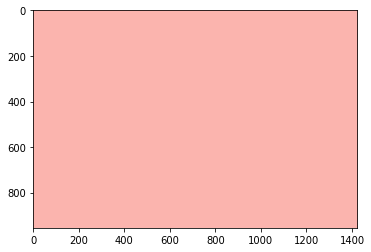

In [89]:

plt.imshow(image_classification, cmap=default_colormap)
plt.show